# Exoplanets A: Lab Assignment
*Author: Lukas Welzel*

## Purpose
Collect all plots for the assignment.

## WIP - improvements
Notable TODOs:
-


# Setup

## Library import

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
RGbinary = mpl.colors.ListedColormap(['red', 'green'])

import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 300

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# other
from tqdm import tqdm
from copy import deepcopy

## Local library import

In [3]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries
from read_all_planets import read_experiments_hdf5

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data import
We retrieve all the required data for the analysis.

In [4]:
# data is hierarchical dict with all experiment data in the structure:
#   failed_configs:             df with config information for those that failed to run properly
#   run-m_core-VALUE-f-VALUE:   dict with single experiment data    - e.g. run-m_core-3_0-f-0_1
#       header                  dict with header data               - 'burn_min1', 'burn_min2', 'f', 'initial_mass',
#                                                                     'initial_z', 'm_core', 'name', 'path', 'success', 'version_number'
#       history                 df with history data                - 'log_star_age', 'luminosity', 'radius', 'star_mass',
#                                                                     'surface_cell_temperature', 'conv_mx1_top_r', 'conv_mx1_top',
#                                                                     'center_entropy', 'max_entropy', 'log_L', 'log_Teff', 'log_center_T',
#                                                                     'log_center_Rho', 'log_R'
#       global_properties       df with global data at step         - 'step', 'model_number', 'num_zones', 'star_age', 'Teff',
#                                                                     'photosphere_L', 'photosphere_r', 'star_mass', 'power_nuc_burn'
#       zone_properties         df with zone data at step           - 'zone', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H',
#                                                                     'y_mass_fraction_He', 'z_mass_fraction_metals', 'mu', 'grada',
#                                                                     'opacity', 'gradT', 'gradr', 'sch_stable', 'ledoux_stable'
#   run-m_core-VALUE-f-VALUE...
#
# the zone_properties df has a hierarchical index "step" which corresponds to the "step" column in the global_properties df

DATA_FILE = "exoplanet_A_MESA_lab_GS_RS.hdf5"

data = read_experiments_hdf5(loc=DATA_FILE)

failed_experiments = deepcopy(data["failed_configs"])
del data["failed_configs"]

# Data processing
## Preprocessing

In [5]:
entries = [key for key in data.keys()]

def get_data_from_hist(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["history"][cols]] for entry in entries]

m_cores = np.array([entry[0] for entry in get_data_from_hist([])])
fs = np.array([entry[1] for entry in get_data_from_hist([])])

cross = np.array([m_cores, fs]).T
max_m_core = np.max(m_cores)
max_f = np.max(fs)

def get_data_from_zone(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["zone_properties"][cols]] for entry in entries]

def get_data_from_global(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["global_properties"][cols]] for entry in entries]

def get_final_values_from_zones(_planets):
    for i, planet in enumerate(_planets):
        _planets[i][-1] = planet[-1].xs(planet[-1].index.get_level_values(0)[-1])
    return _planets

In [6]:
def color_m_core(_m_core):
    return mpl.colormaps['viridis'](_m_core / max_m_core)

def color_f(_f):
    return mpl.colormaps['viridis'](np.log10(max_f) / np.log10(_f))

def size_m_core(_m_core):
    return 20. * (_m_core / max_f) + 1.


### Failed Runs

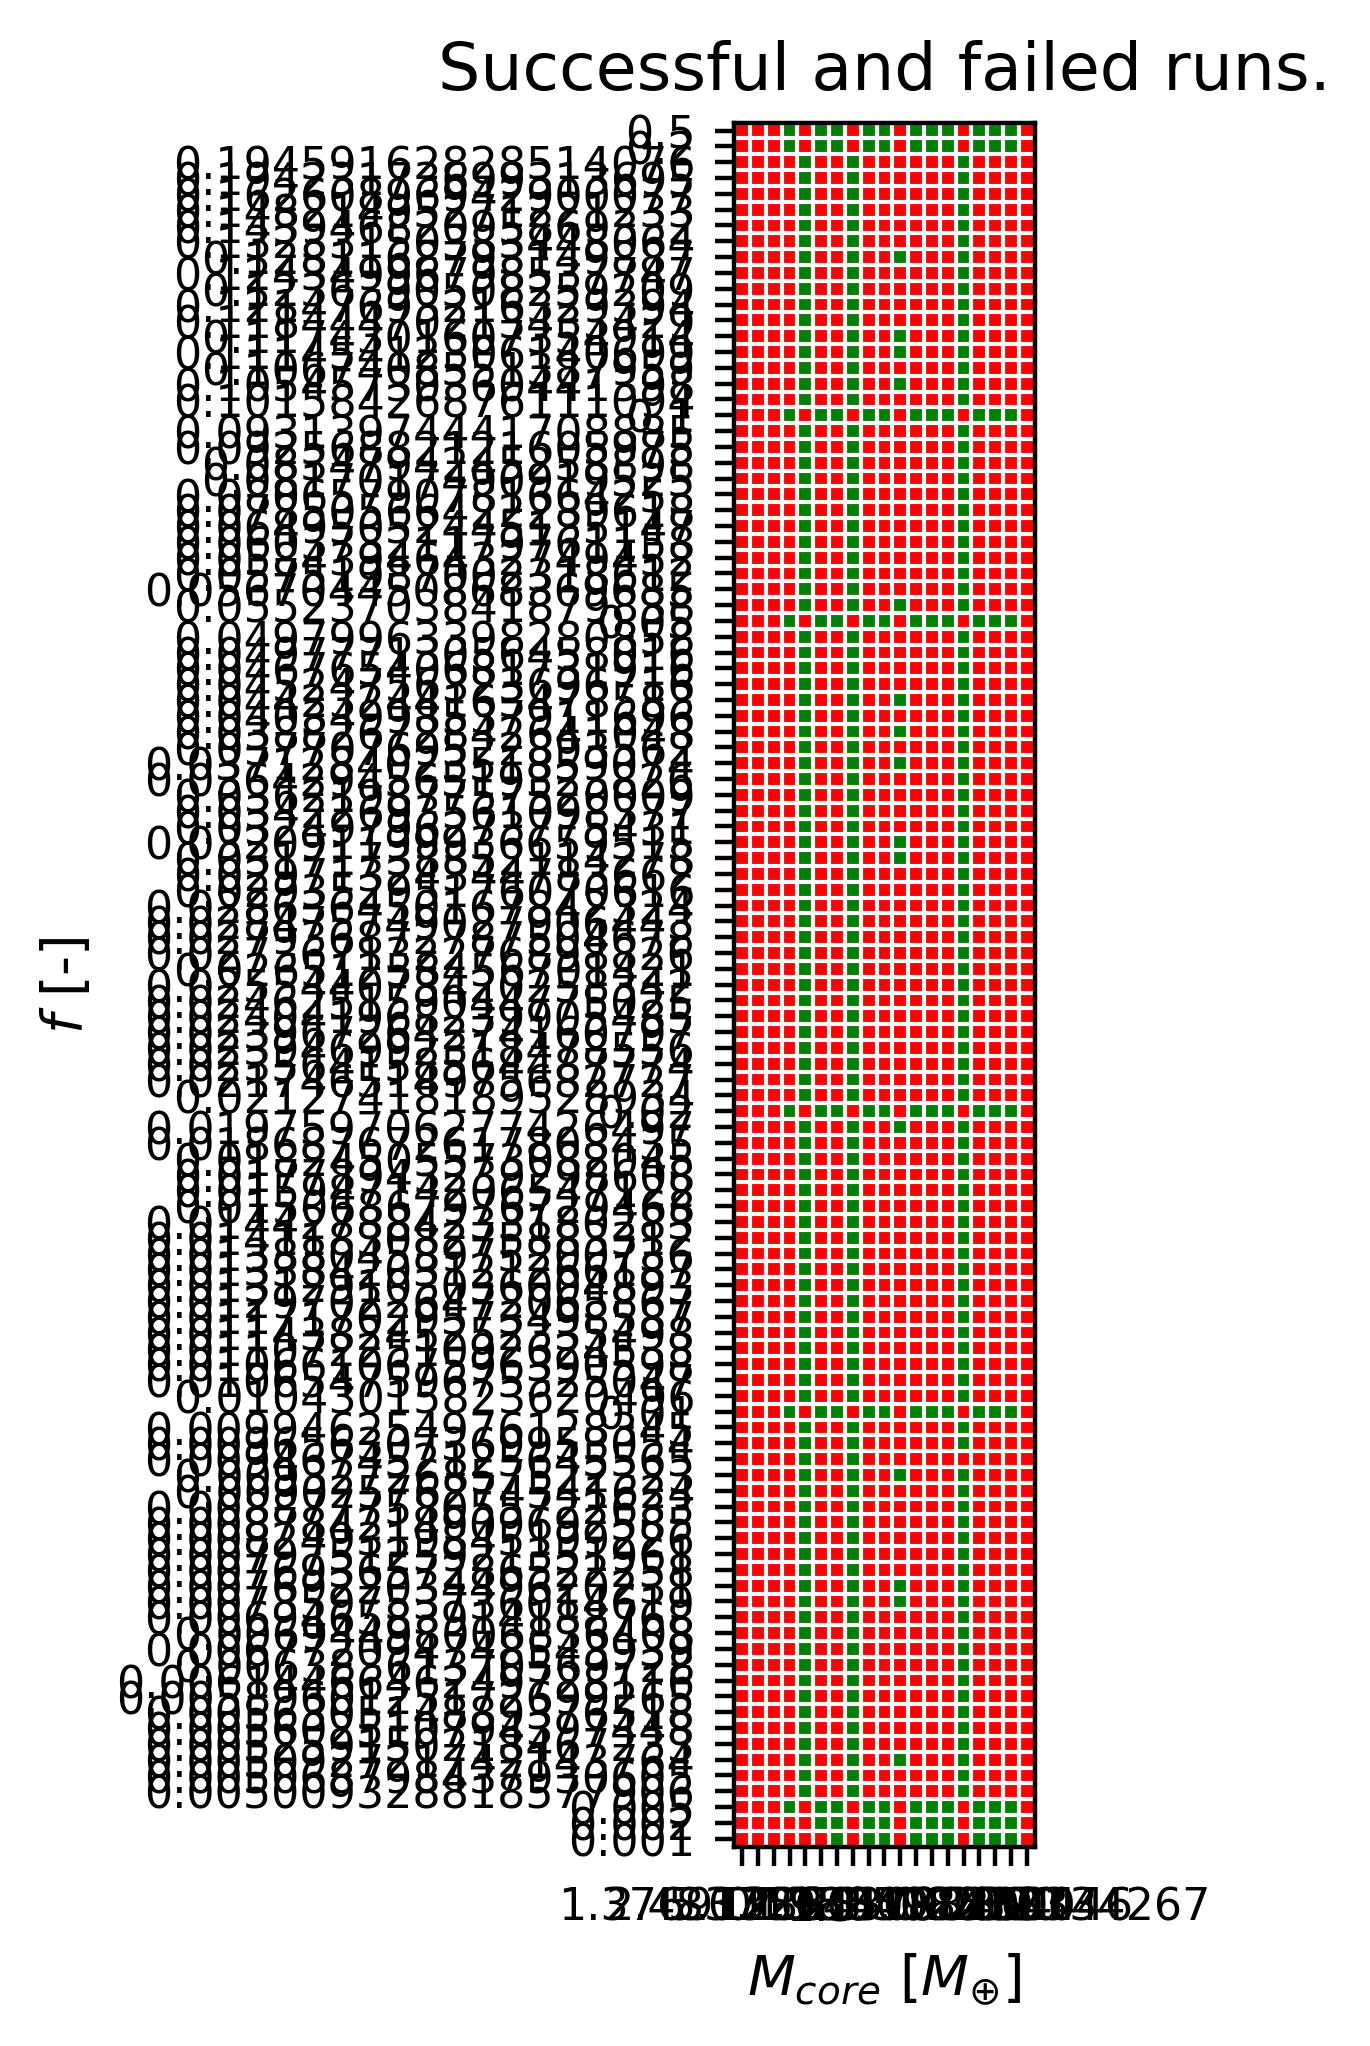

In [7]:
%matplotlib inline
unique_m_cores = np.unique(np.append(m_cores, failed_experiments["m_core"].to_numpy()))
unique_fs = np.unique(np.append(fs, failed_experiments["f"].to_numpy()))

mss, fss = np.meshgrid(unique_m_cores, unique_fs)
av = np.zeros_like(mss)

for i, __ in enumerate(unique_m_cores):
    for j, __ in enumerate(unique_fs):
        if np.any(np.isclose(cross, [mss[j, i], fss[j, i]]).all(1)):
            av[j, i] = 1.

fig, ax = plt.subplots(constrained_layout=True, figsize=(5,5))
im = ax.imshow(av, origin="lower", cmap=RGbinary)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)

ax.set_xticks(np.arange(0, len(unique_m_cores), 1))
ax.set_yticks(np.arange(0, len(unique_fs), 1))
ax.set_xticks(np.arange(-0.5, len(unique_m_cores), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(unique_fs), 1), minor=True)
ax.set_xticklabels(unique_m_cores)
ax.set_yticklabels(unique_fs)

ax.grid(which='minor', color='w', linestyle='solid', linewidth=0.75)
ax.tick_params(which='minor', bottom=False, left=False)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_title("Successful and failed runs.")
ax.set_xlabel(r"$M_{core}$ [$M_{\oplus}$]")
ax.set_ylabel(r"$f$ [-]")

plt.show()

## Plotting

### Radius vs time
The evolution of the radius of the planets with time.

In [8]:
%matplotlib inline
planets = get_data_from_hist(["radius", "log_star_age"])

def generate_rad_time_go_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["radius"].to_numpy()
    log_star_age = planet[2]["log_star_age"].to_numpy()
    trace = go.Scatter3d(x=radius,
                         y=log_star_age,
                         z=np.ones_like(radius) * m_core,
                         mode='markers', marker={"size":np.log10(radius * 109) * 10,
                                                 "color":np.tile(color_f(f), (len(radius), 1)),
                                                 # "colorscale": 'Viridis',
                                                 "opacity":0.8
                                                 }
                         )
    return trace

traces = [generate_rad_time_go_trace(planet) for planet in planets]

fig = go.Figure(data=traces,)

fig.update_layout(
    scene = dict(
        xaxis_title='Planet Radius []',
        yaxis_title='Star Age [log]',
        zaxis_title='f [-]',
    zaxis=dict(type='log')
    ),
)

# ply.iplot(fig, filename='radius_age')
fig.write_html("radius_age_f_m_core.html")

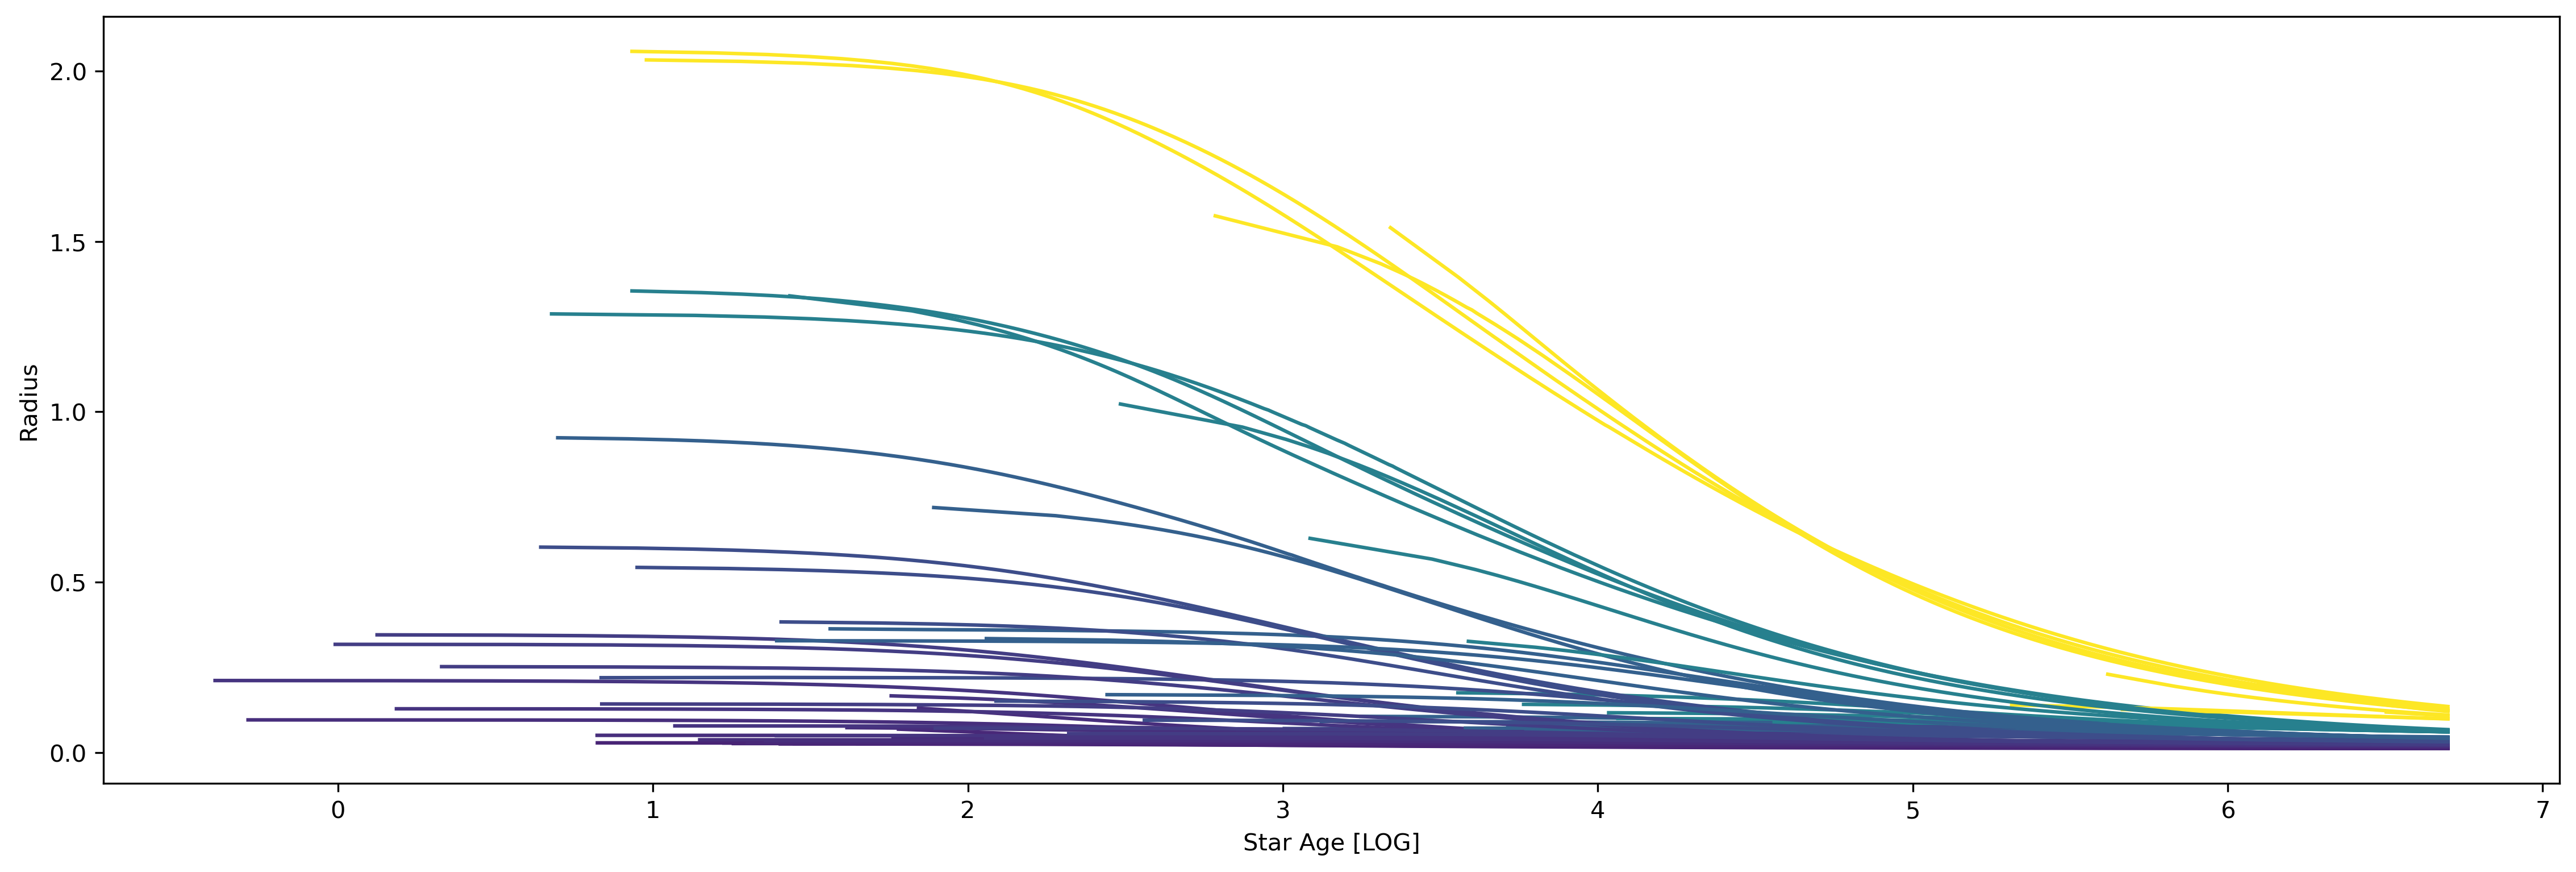

In [213]:
planets = get_data_from_hist(["radius", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_rad_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["radius"].to_numpy()
    # radius = radius / np.max(radius)
    log_star_age = planet[2]["log_star_age"].to_numpy()
    # log_star_age = (log_star_age - np.min(log_star_age))/ np.max(log_star_age - np.min(log_star_age))
    ax0.plot(log_star_age, radius, c=color_f(f))
    return

[generate_rad_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel("Radius")

plt.savefig("radius_star_age.png", dpi=350)
plt.show()

### final mass vs radius
The final mass vs. the final radius of the planets.

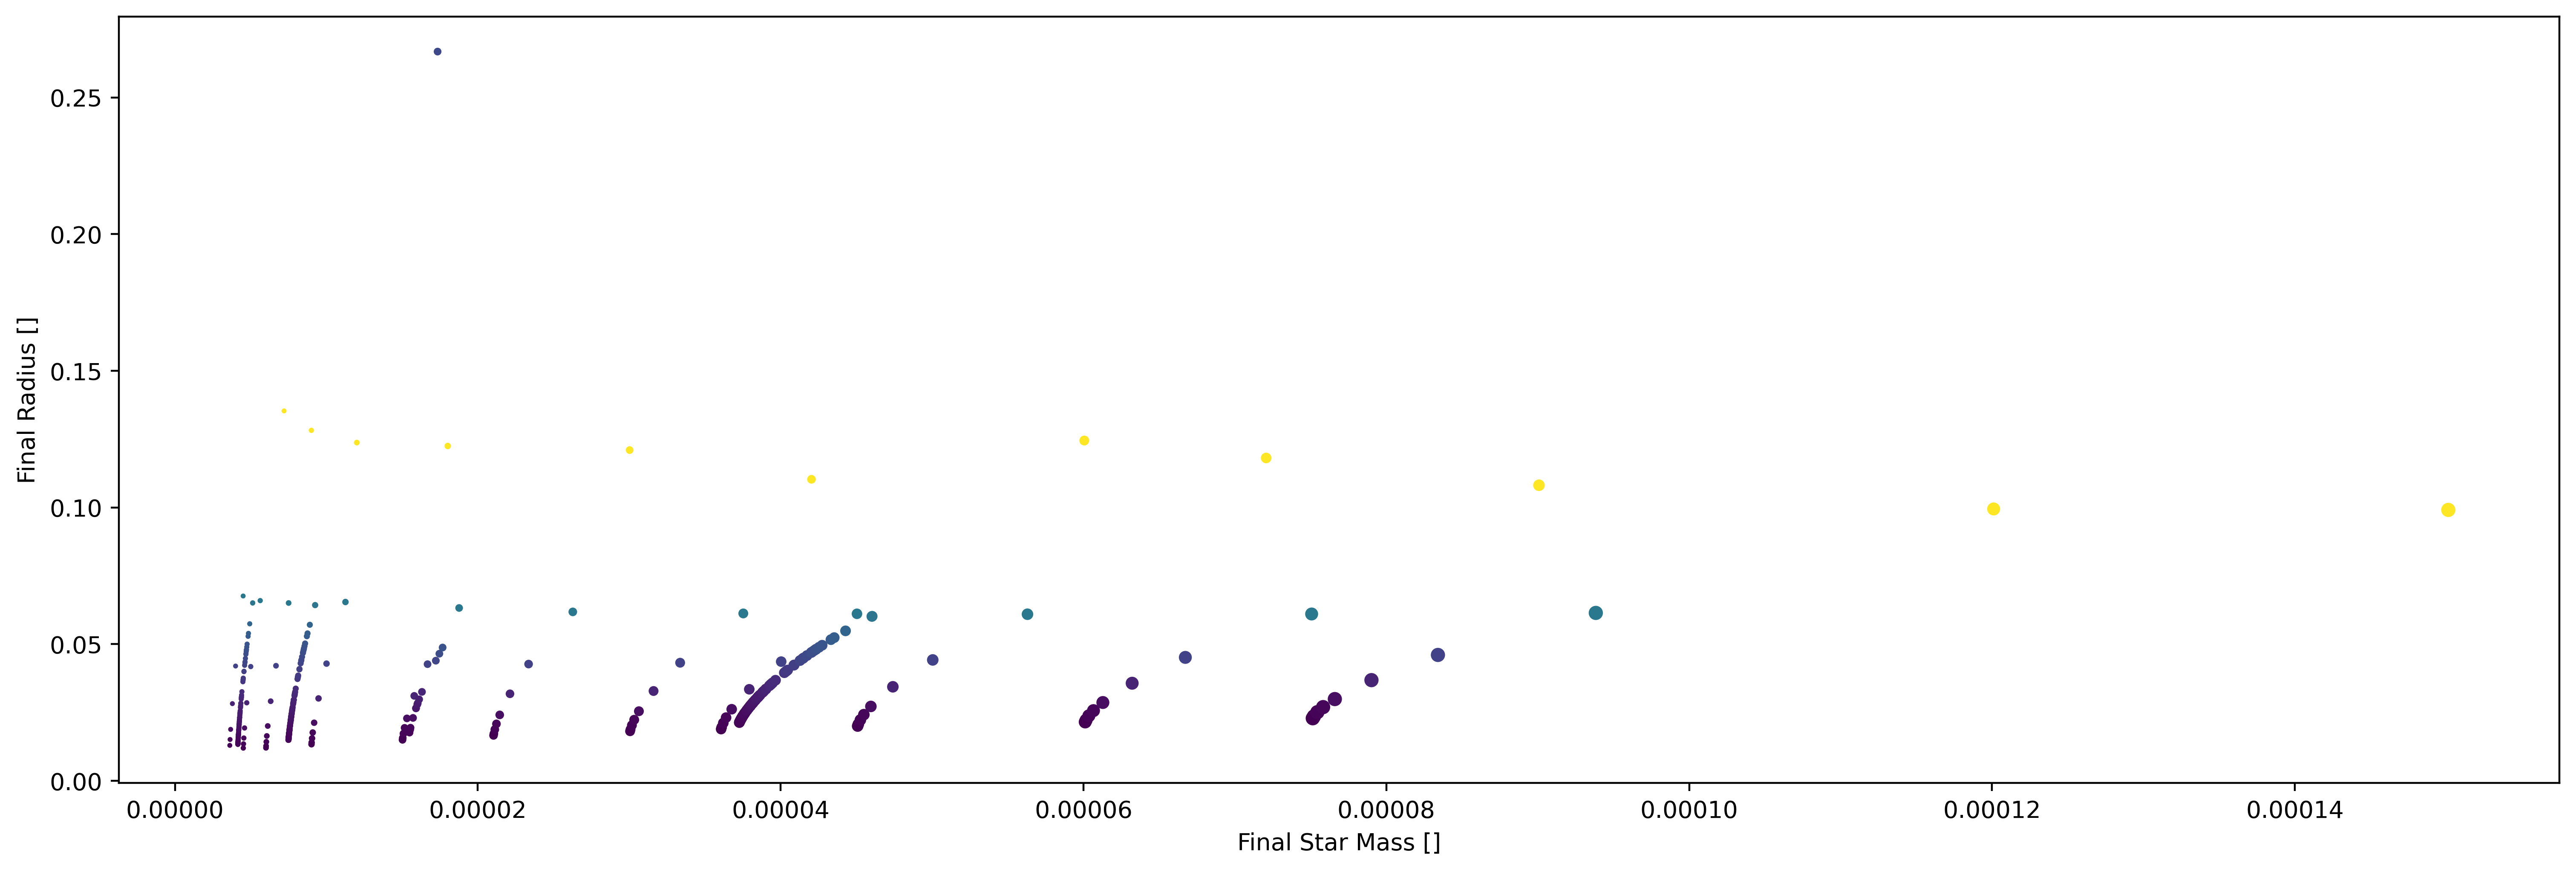

In [9]:
planets = get_data_from_hist(["radius", "star_mass"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def format_mass_rad(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["radius"].to_numpy()
    star_mass = planet[2]["star_mass"].to_numpy()
    return [star_mass[-1], radius[-1], m_core, f]

trace = np.array([format_mass_rad(planet) for planet in planets]).T
ax0.scatter(trace[0], trace[1], s=trace[2], c=trace[3])

ax0.set_xlabel("Final Star Mass []")
ax0.set_ylabel("Final Radius []")

plt.savefig("final_mass_radius.png", dpi=350)
plt.show()

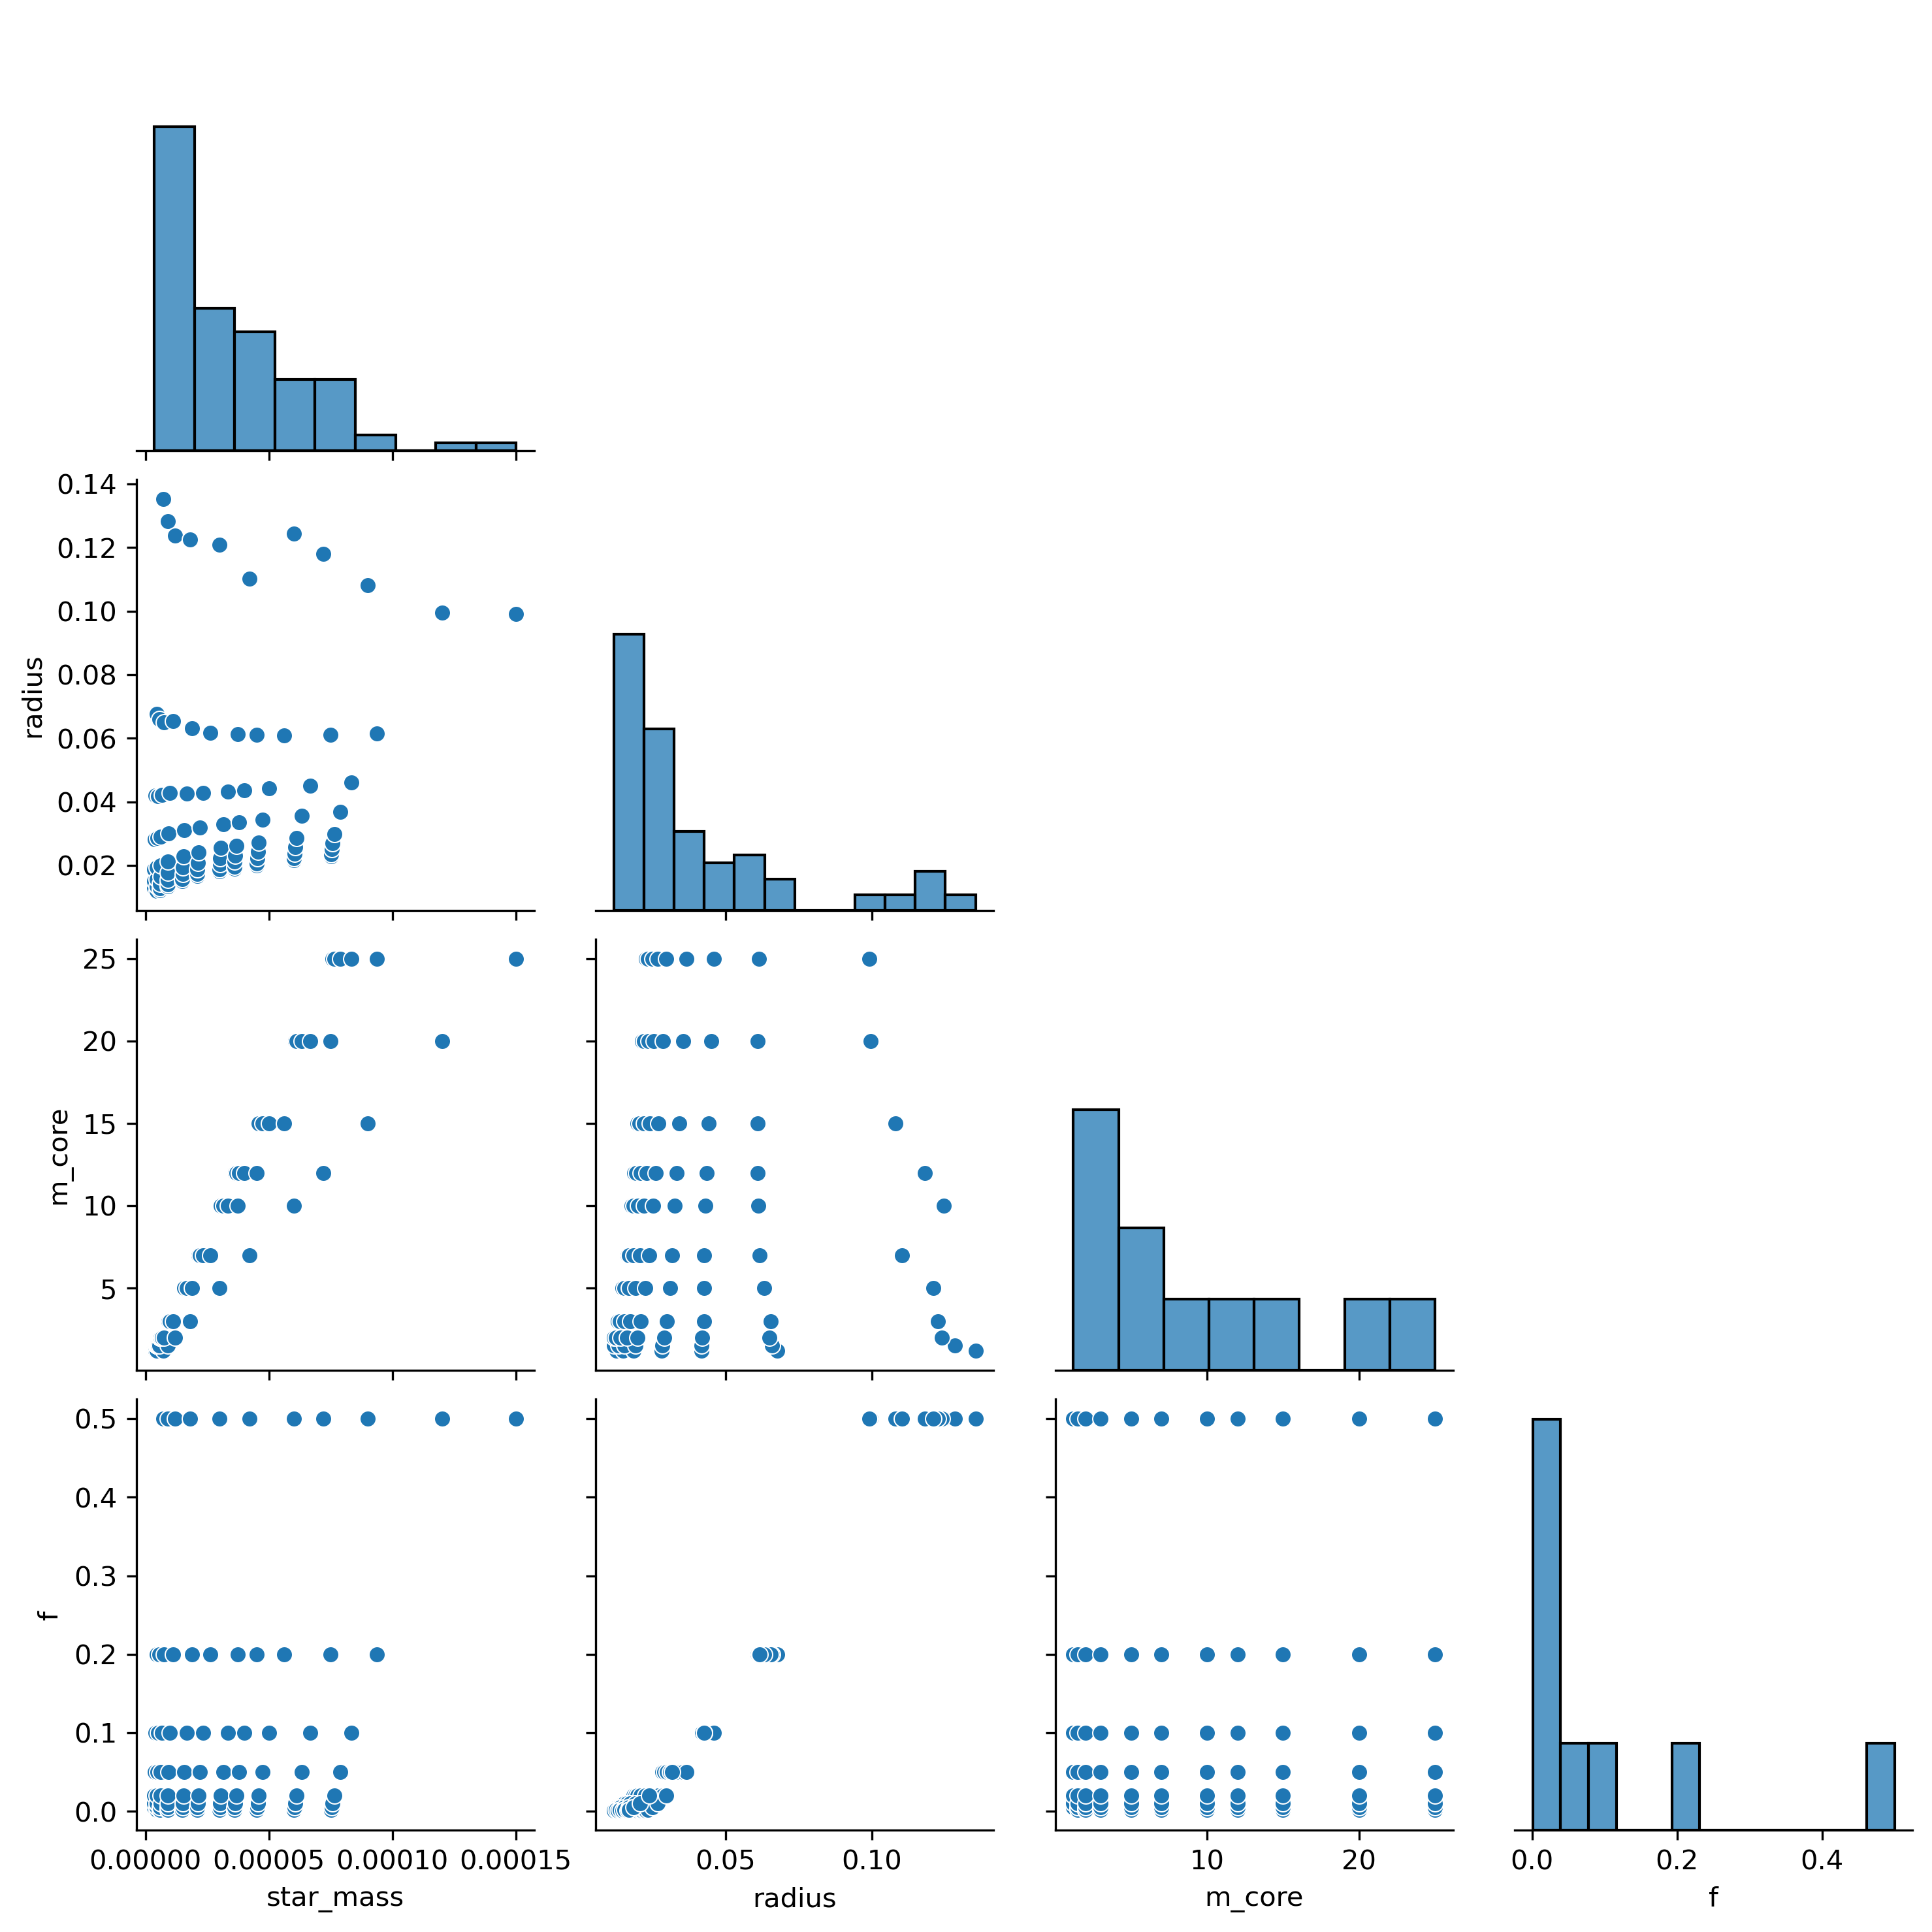

In [210]:
planets = get_data_from_hist(["radius", "star_mass"])
trace = np.array([format_mass_rad(planet) for planet in planets]).T

df = pd.DataFrame(data=trace.T, columns=["star_mass", "radius", "m_core", "f"])

sns.pairplot(df, kind="scatter", diag_kind="hist", corner=True)
plt.show()

### final radiative and adiabatic gradient vs radius
The final radiative and adiabatic gradient (both in the same plot) vs. the radius for each planet.

In [205]:
# from zone_properties: 'grada', 'gradT', 'gradr',
# from history: radius
planets = get_data_from_zone(['logR', 'grada', 'gradr'])
planets = get_final_values_from_zones(planets)

def generate_rad_grads_go_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["logR"].to_numpy()
    grada = planet[2]["grada"].to_numpy()
    gradr = planet[2]["gradr"].to_numpy()

    grada_trace = go.Scatter3d(x=radius,
                         y=grada,
                         z=np.ones_like(radius) * m_core,
                         mode='markers', marker={"size":1,
                                                 "color":np.tile(color_f(f), (len(radius), 1)),
                                                 # "colorscale": 'Viridis',
                                                 "opacity":0.8
                                                 }
                         )

    gradr_trace = go.Scatter3d(x=radius,
                     y=gradr,
                     z=np.ones_like(radius) * m_core,
                     mode='markers', marker={"size":1,
                                                 "color":np.tile(color_f(f), (len(radius), 1)),
                                                 # "colorscale": 'Viridis',
                                                 "opacity":0.8
                                                 }
                     )

    return [grada_trace, gradr_trace]

traces = list(np.array([generate_rad_grads_go_trace(planet) for planet in planets]).flatten())

# print(traces.shape)

fig = go.Figure(data=traces,)

fig.update_layout(
    scene = dict(
        xaxis_title='Planet Radius [log]',
        yaxis_title='Gradient[-]',
        zaxis_title='m_core []',
    # zaxis=dict(type='log')
    ),
)

# ply.iplot(fig, filename='radius_gradients')
fig.write_html("radius_gradients.html")

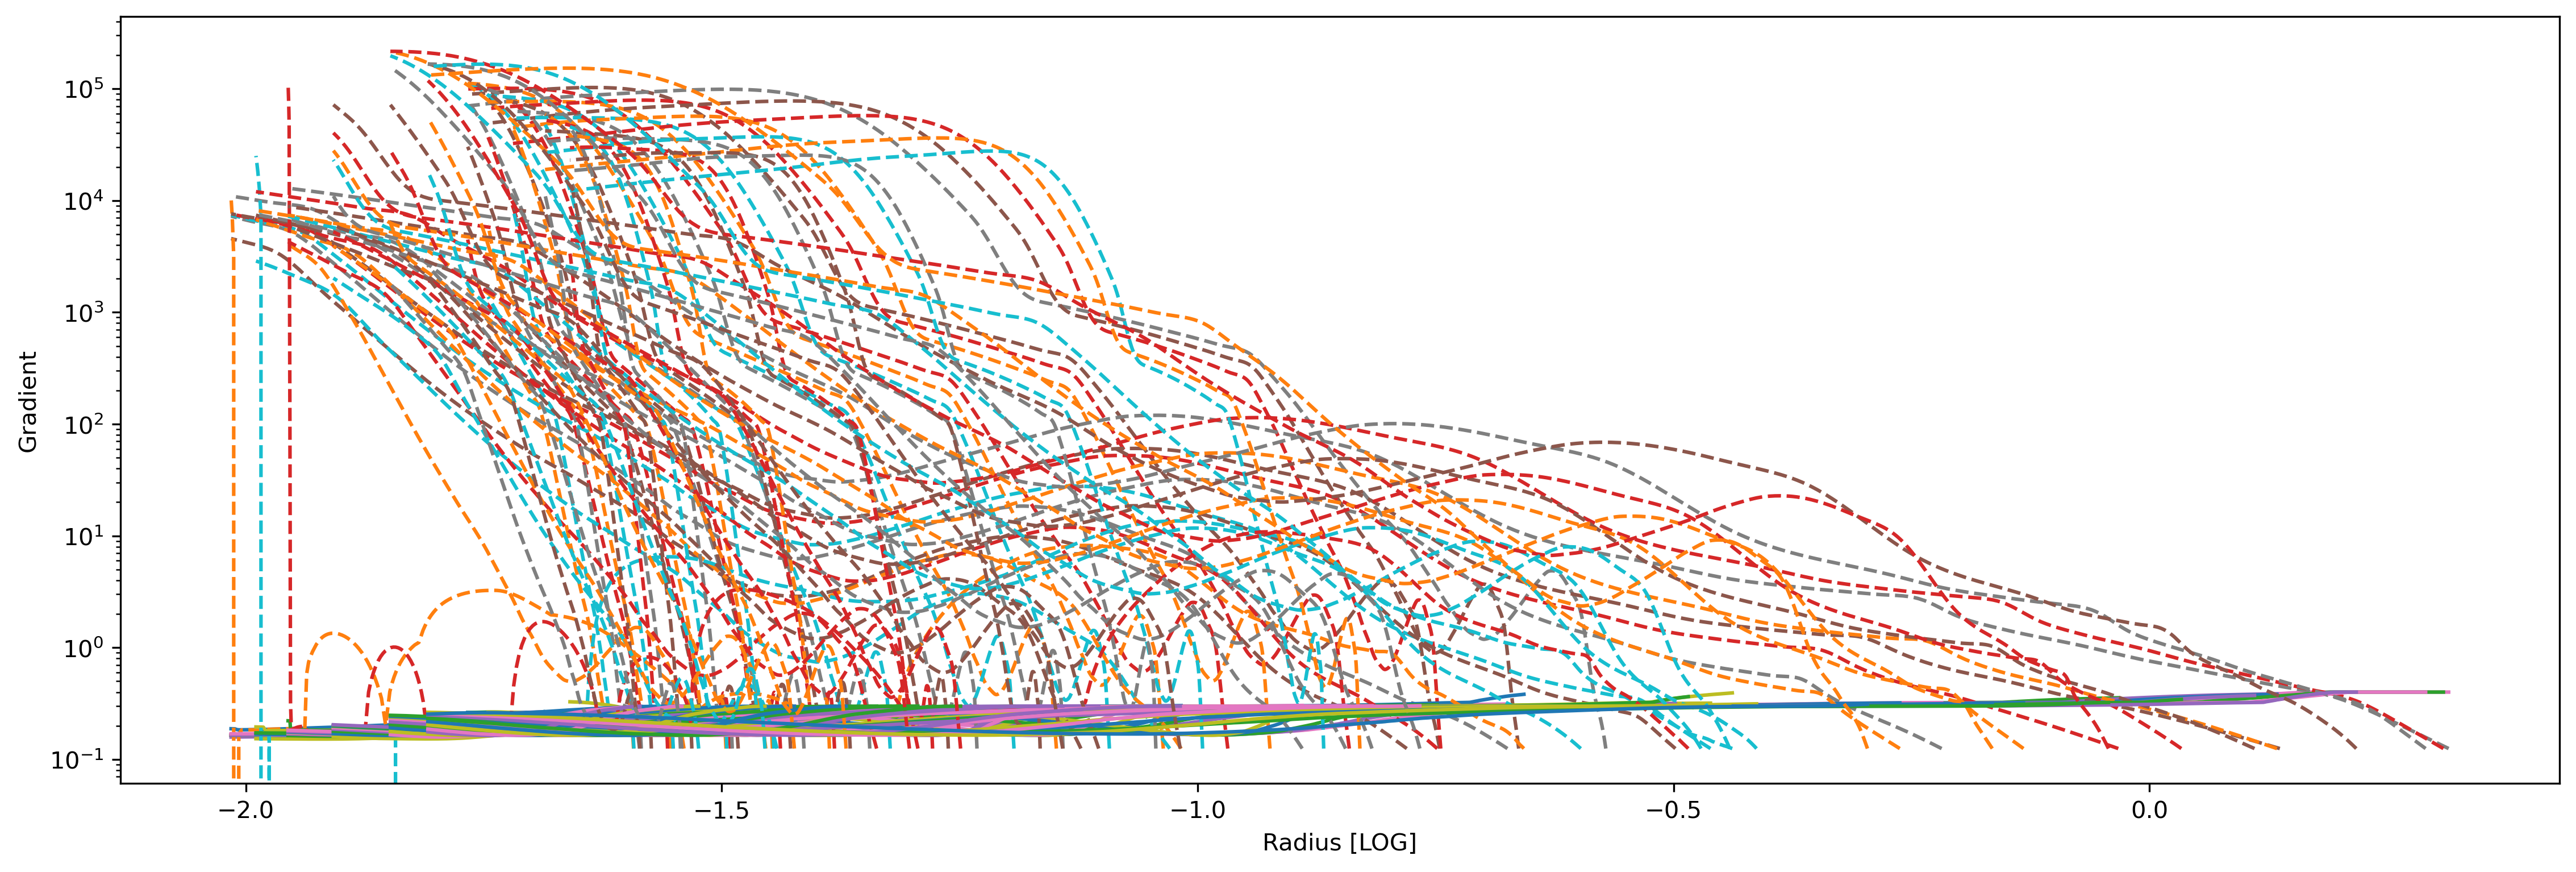

In [188]:
# from zone_properties: 'grada', 'gradT', 'gradr',
# from history: radius
planets = get_data_from_zone(['logR', 'grada', 'gradr'])
planets = get_final_values_from_zones(planets)

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_rad_grads_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["logR"].to_numpy()
    grada = planet[2]["grada"].to_numpy()
    gradr = planet[2]["gradr"].to_numpy()

    ax0.plot(radius, grada, ls="solid")
    ax0.plot(radius, gradr, ls="dashed")
    return

[generate_rad_grads_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Radius [LOG]")
ax0.set_ylabel("Gradient")
ax0.set_yscale("log")

plt.savefig("radius_gradients.png", dpi=350)
plt.show()

### final temperature vs pressure
The final temperature-pressure profile for each planet atmosphere.

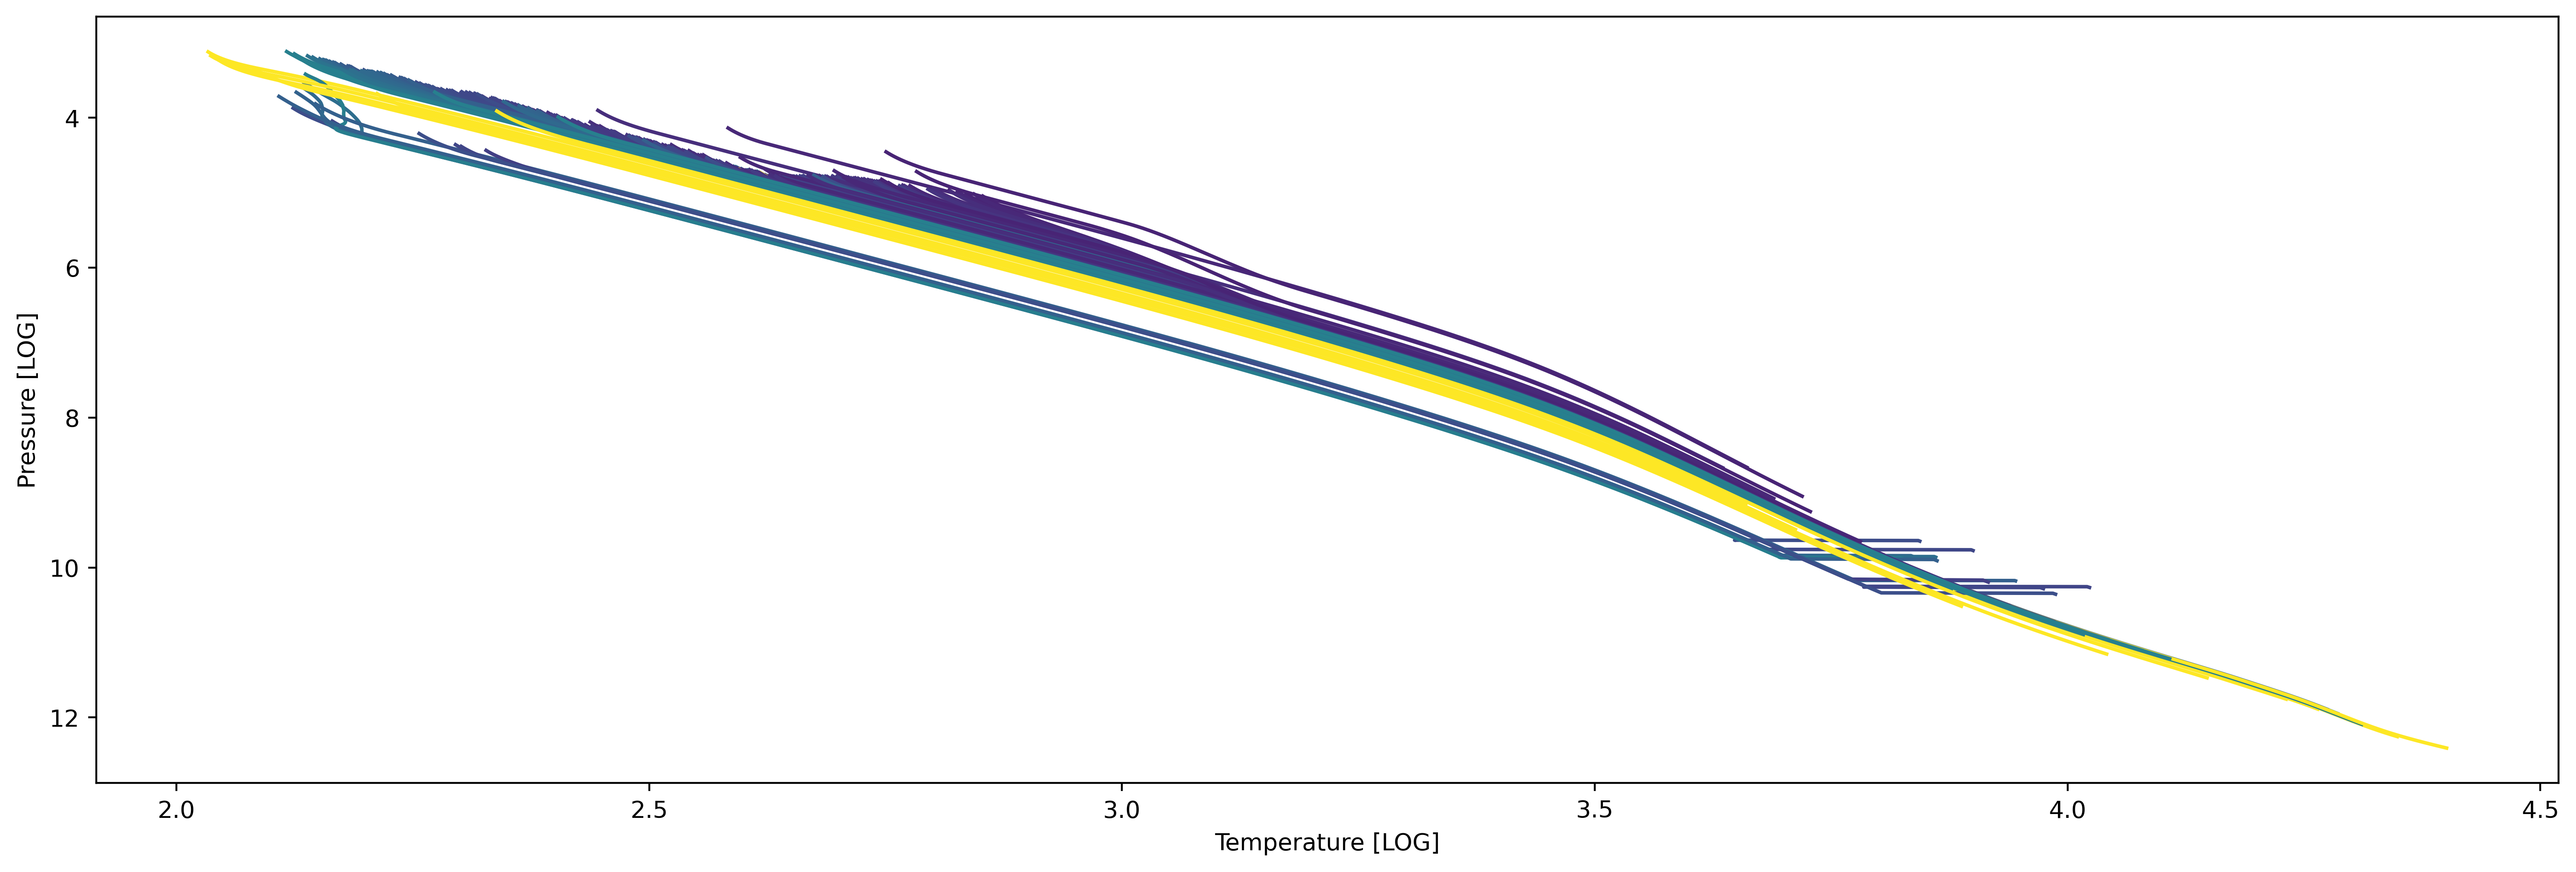

In [10]:
# from zone_properties: 'logT', 'logP'
planets = get_data_from_zone(['logT', 'logP'])
planets = get_final_values_from_zones(planets)

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_temp_pressure_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    logT = planet[2]["logT"].to_numpy()
    logP = planet[2]["logP"].to_numpy()

    ax0.plot(logT, logP, ls="solid", c=color_f(f))
    return

[generate_temp_pressure_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Temperature [LOG]")
ax0.set_ylabel("Pressure [LOG]")
ax0.invert_yaxis()

plt.savefig("temp_pressure.png", dpi=350)
plt.show()

In [ ]:
def rho_mod_polytrop_EOS(P, rho_0, K, n=1.5):
    """
    Modified polytropic equation of state
    """
    return rho_0 + K * P ** ( (n+ 1) / n)

def temp_mod_polytrop_EOS(rho, P, K, mu, H):
    """
    Ideal gas assumption
    """
    return P / (rho * K) * mu * H

def mass_radius_polytrop(m, K, G):
    """
    Mass radius relationship for a n=1.5 polytrop
    """
    return m ** 3 * K / (0.4242 * G)

### mass vs age

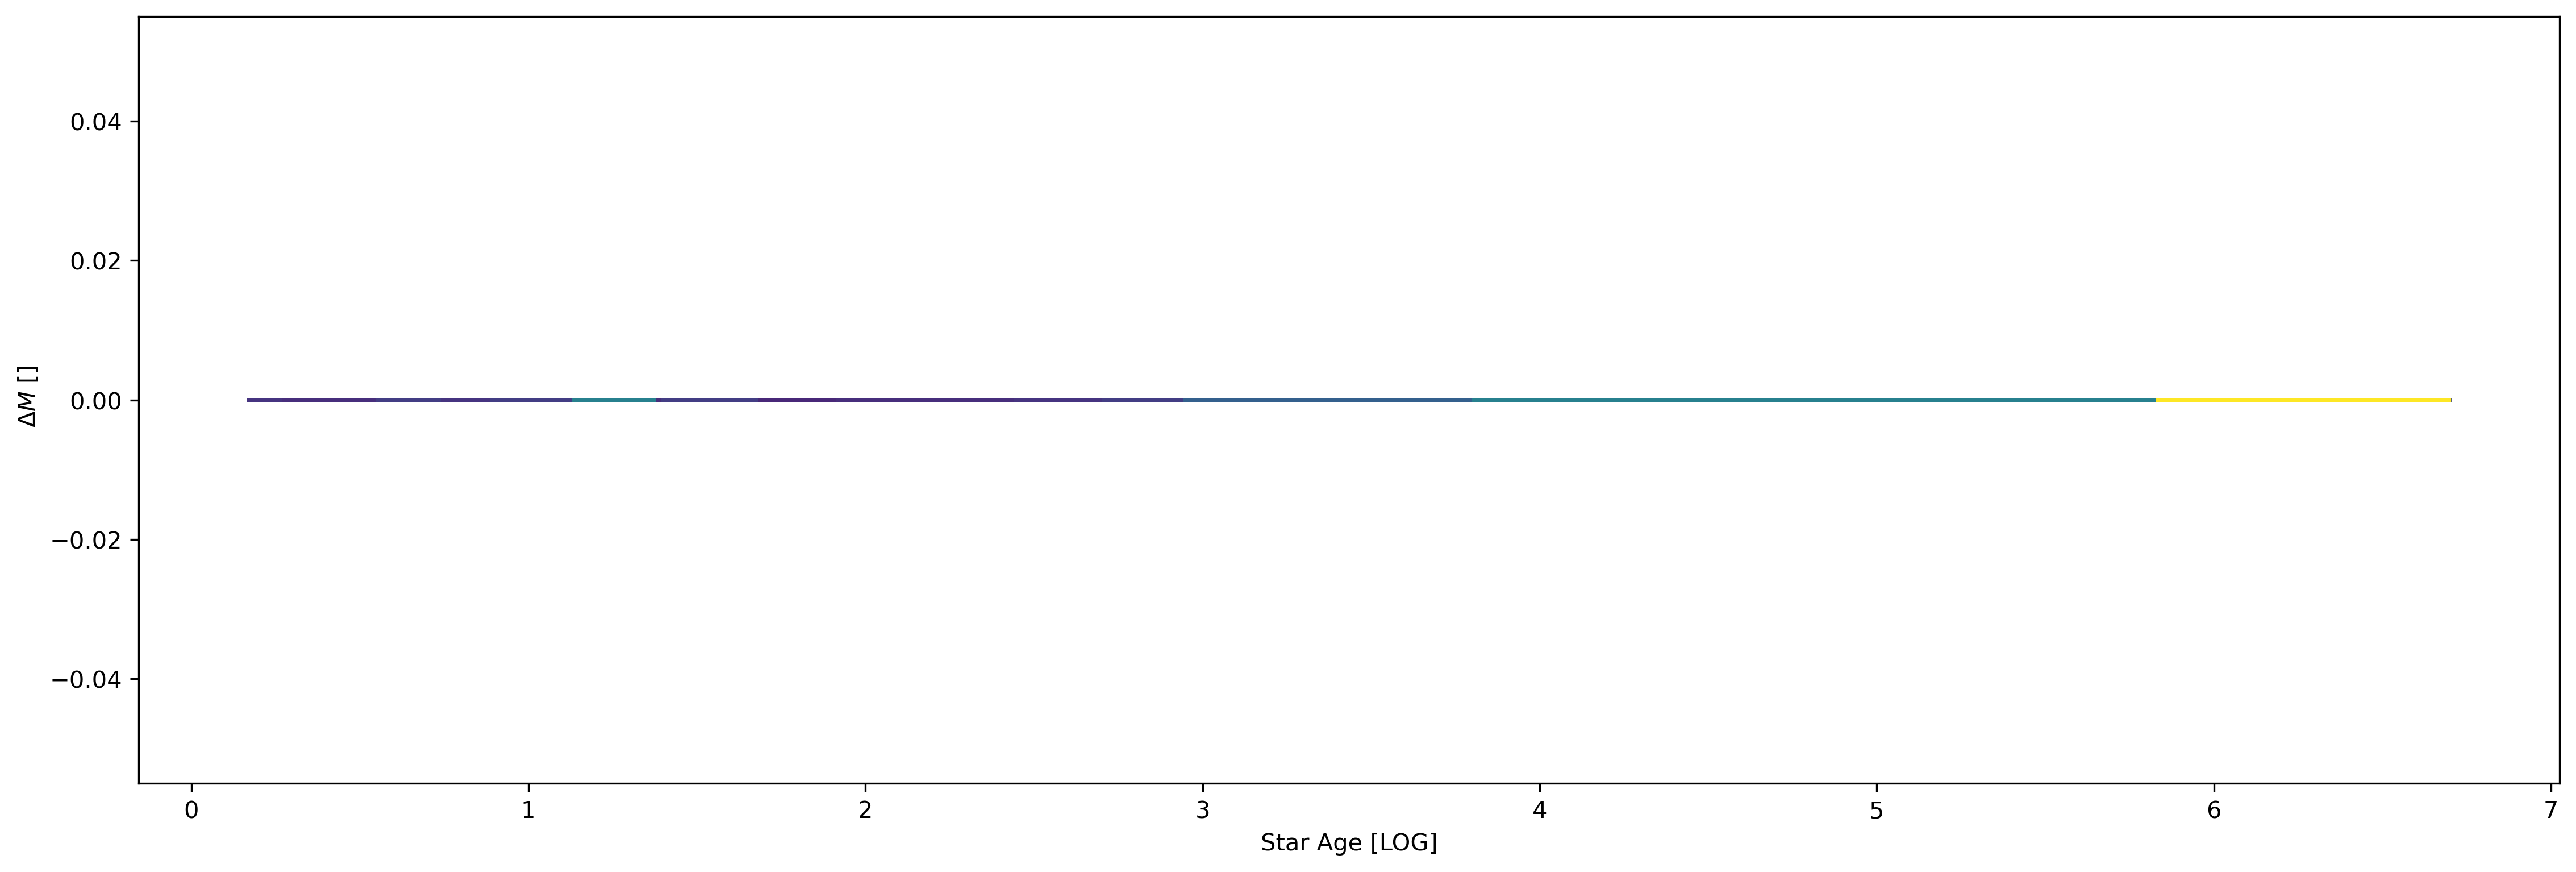

In [217]:
planets = get_data_from_hist(["star_mass", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_mass_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    star_mass = planet[2]["star_mass"].to_numpy()
    star_mass = star_mass / np.max(star_mass)
    d_star_mass = [star_mass[i+1] - star_mass[i] for i in range(len(star_mass) - 1)]
    log_star_age = planet[2]["log_star_age"].to_numpy()[1:]
    # log_star_age = (log_star_age - np.min(log_star_age))/ np.max(log_star_age - np.min(log_star_age))
    ax0.plot(log_star_age, d_star_mass, c=color_f(f))
    return

[generate_mass_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel(r" $\Delta M$ []")

plt.savefig("mass_star_age.png", dpi=350)
plt.show()

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2